### Imports

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import nltk
import numpy as np
import pandas as pd
from netgraph import Graph
import re
from collections import Counter, defaultdict
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from nltk.util import ngrams
from matplotlib.patches import FancyArrowPatch
#from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import math

np.set_printoptions(threshold=np.inf)

### Recogemos los datos limpios

In [2]:
df_clean = pd.read_csv('../data/train_clean.csv')

### Tokenización

In [3]:
# Tokenizamos el texto
df_clean_tokens = pd.DataFrame()
df_clean_tokens['text'] = df_clean['text'].apply(nltk.word_tokenize)
df_clean_tokens['label'] = df_clean['label']

### Split train/test

In [4]:
# Dividimos el dataset en train y test con la función sample de pandas
df_train, df_test = train_test_split(df_clean_tokens, test_size=0.2, random_state=777)

print("Ejemplos usados para entrenar: ", len(df_train))
print("Ejemplos usados para test: ", len(df_test))

Ejemplos usados para entrenar:  16201
Ejemplos usados para test:  4051


### Etiquetamos texto

In [5]:
# Si label es 0, incluimos en text True, False si es 1
for i in range(len(df_train['label'])):
	if df_train['label'].iloc[i] == 0:
		df_train['text'].iloc[i].append("TRUE")
	else:
		df_train['text'].iloc[i].append("FALSE")
  
df_train = df_train.drop('label', 1)

C:\Users\jabel\AppData\Local\Temp\ipykernel_7348\2436280572.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_train = df_train.drop('label', 1)


## Caso 1: Unigramas

In [ ]:
# Preparamos los datos para procesar Apriori
te1 = TransactionEncoder()
te_ary1 = te1.fit(df_train['text']).transform(df_train['text'])
df_apriori1 = pd.DataFrame(te_ary1, columns=te1.columns_)
df_apriori1

In [ ]:
frecuencias_true = defaultdict(int)
frecuencias_fake = defaultdict(int)

for index, noticia in df_train.iterrows():
	es_verdadera = 'TRUE' in noticia['text']  # Comprobamos si la noticia es verdadera o falsa
	palabras = set(noticia['text'])  # Utilizamos un conjunto para evitar contar varias veces la misma palabra en una noticia
	
	for palabra in palabras:
		if es_verdadera:
			frecuencias_true[palabra] += 1
		else:
			frecuencias_fake[palabra] += 1

# Crear un DataFrame con las frecuencias de palabras en noticias verdaderas
df_true = pd.DataFrame({'Palabra': list(frecuencias_true.keys()), 'Frecuencia_true': list(frecuencias_true.values())})

# Crear un DataFrame con las frecuencias de palabras en noticias falsas
df_fake = pd.DataFrame({'Palabra': list(frecuencias_fake.keys()), 'Frecuencia_fake': list(frecuencias_fake.values())})

# Combinar los DataFrames por la columna 'Palabra'
df_frecs = pd.merge(df_true, df_fake, on='Palabra', how='outer').fillna(0)

In [ ]:
# Obtenemos en una lista las palabras con frecuencia menor a 50
words_less_50 = []
for index, noticia in df_frecs.iterrows():
	if noticia['Frecuencia_true'] + noticia['Frecuencia_fake'] < 50:
		words_less_50.append(noticia['Palabra'])

In [ ]:
words_more_50 = set(df_apriori1.columns.tolist()) - set(words_less_50)
df_apriori1 = df_apriori1[words_more_50]

In [ ]:
# Conjuntos de items frecuentes
itemsets_frecuentes1 = apriori(df_apriori1, min_support=0.2, use_colnames=True)
itemsets_frecuentes1

In [ ]:
itemsets_frecuentes1.count()

In [ ]:
# Reglas de asociación apriori
reglas_unigramas = association_rules(itemsets_frecuentes1, metric="confidence", min_threshold=0.2)
reglas_unigramas

In [ ]:
# Mostramos las reglas de asociación ordenadas por confianza y mostramos el top 25
reglas_unigramas.sort_values(by='confidence', ascending=False).head(25)

In [ ]:
# Vemos cuantas reglas hay con confianza entre 0.9 y 1
reglas_unigramas[(reglas_unigramas['confidence'] >= 0.9) & (reglas_unigramas['confidence'] <= 1)].count()

In [ ]:
# Escogemos las reglas que contienen solamente True o solamente False en el consecuente
reglas_VoF1 = reglas_unigramas[(reglas_unigramas['consequents'] == frozenset({'TRUE'})) | (reglas_unigramas['consequents'] == frozenset({'FALSE'}))]
reglas_VoF1.sort_values(by=['confidence'], ascending=False)

In [ ]:
# Hacemos un dataframe con las reglas que contienen TRUE y otro para FALSE
reglas_true1 = reglas_VoF1[reglas_VoF1['consequents'] == frozenset({'TRUE'})]
reglas_false1 = reglas_VoF1[reglas_VoF1['consequents'] == frozenset({'FALSE'})]

In [ ]:
# Vemos las confianzas maximas y minimas de las reglas que contienen TRUE y FALSE
print("Confianza máxima de las reglas que contienen TRUE: ", reglas_true1['confidence'].max())
print("Confianza mínima de las reglas que contienen TRUE: ", reglas_true1['confidence'].min())
print("Confianza máxima de las reglas que contienen FALSE: ", reglas_false1['confidence'].max())
print("Confianza mínima de las reglas que contienen FALSE: ", reglas_false1['confidence'].min())

In [ ]:
reglas_false1.sort_values(by=['confidence'], ascending=False).head(25)

In [ ]:
# Creamos un gráfico donde mostremos las confianzas que tienen true y false
fig, ax = plt.subplots(figsize=(10, 5))
bin_edges = np.arange(0, 1, 0.05)
ax.hist(reglas_true1['confidence'], bins=bin_edges, label='TRUE', rwidth=0.85, color='#6c78d4')
ax.hist(reglas_false1['confidence'], bins=bin_edges, label='FALSE', rwidth=0.85, color='#faed57')
ax.set_xlabel('Confianza')
ax.set_ylabel('Frecuencia')
plt.gca().set_axisbelow(True)
plt.gca().yaxis.grid(True, which='major')
plt.gca().set_xticks(np.arange(0, 1, 0.05))
plt.gca().set_yticks(np.arange(0, 130, 20))
ax.set_title('Confianza de las reglas que contienen TRUE y FALSE')
ax.legend(loc='upper right')
plt.savefig('../images/confidence_rules.png', bbox_inches='tight')
plt.show()

In [ ]:
print(len(reglas_true1))
print(len(reglas_false1))

In [ ]:
# Vemos las 10 reglas que tienen mayor confianza
reglas_VoF1.sort_values(by=['confidence'], ascending=False).head(10)

In [ ]:
# Cogemos 30 consecuentes con reglas de confianza mayores y solo tienen un item en el consecuente
lista_consecuentes = reglas_unigramas[(reglas_unigramas['confidence'] >= 0.9) & (reglas_unigramas['confidence'] <= 1) & (reglas_unigramas['consequents'].apply(lambda x: len(x) == 1))].sort_values(by=['confidence'], ascending=False)['consequents'].tolist()
lista_consecuentes

# La lista anterior repite items. Quiero los 30 items primeros unicos
lista_consecuentes = list(set(lista_consecuentes))
lista_consecuentes = lista_consecuentes[:30]

In [ ]:
# Reglas que no tienen TRUE
reglas_sin_true = reglas_unigramas[~reglas_unigramas['antecedents'].apply(lambda x: 'TRUE' in x)]
reglas_sin_true = reglas_sin_true[~reglas_unigramas['consequents'].apply(lambda x: 'TRUE' in x)]

# Le quitamos las reglas que tengan new en el consecuente
reglas_sin_true = reglas_sin_true[~reglas_sin_true['consequents'].apply(lambda x: 'new' in x)]
reglas_sin_true = reglas_sin_true[~reglas_sin_true['consequents'].apply(lambda x: 'time' in x)]


In [ ]:
# Cogemos de reglas_unigramas las 30 reglas con mayor confianza con un consecuente que pertenece a la lista anterior y un antecedente y TRUE no esta en los antecedentes
reglas11 = reglas_sin_true[(reglas_sin_true['antecedents'].apply(lambda x: frozenset({'TRUE'}) not in x)) & (reglas_sin_true['confidence'] >= 0.9) & (reglas_sin_true['consequents'].apply(lambda x: x in lista_consecuentes)) & (reglas_sin_true['antecedents'].apply(lambda x: len(x) == 1))].sort_values(by=['confidence'], ascending=False).head(30)
reglas21 = reglas_sin_true[(reglas_sin_true['antecedents'].apply(lambda x: frozenset({'TRUE'}) not in x)) & (reglas_sin_true['confidence'] >= 0.9) & (reglas_sin_true['consequents'].apply(lambda x: x in lista_consecuentes)) & (reglas_sin_true['antecedents'].apply(lambda x: len(x) == 2))].sort_values(by=['confidence'], ascending=False).head(30)
reglas31 = reglas_sin_true[(reglas_sin_true['antecedents'].apply(lambda x: frozenset({'TRUE'}) not in x)) & (reglas_sin_true['confidence'] >= 0.9) & (reglas_sin_true['consequents'].apply(lambda x: x in lista_consecuentes)) & (reglas_sin_true['antecedents'].apply(lambda x: len(x) == 3))].sort_values(by=['confidence'], ascending=False).head(30)
reglas41 = reglas_sin_true[(reglas_sin_true['antecedents'].apply(lambda x: frozenset({'TRUE'}) not in x)) & (reglas_sin_true['confidence'] >= 0.9) & (reglas_sin_true['consequents'].apply(lambda x: x in lista_consecuentes)) & (reglas_sin_true['antecedents'].apply(lambda x: len(x) == 4))].sort_values(by=['confidence'], ascending=False).head(30)

In [ ]:
reglasn1 = reglas41.append(reglas31).append(reglas21).append(reglas11)
reglasn1

In [ ]:
reglasn1_formateadas = []
for index, regla in reglasn1.iterrows():
	antecedentes = list(regla['antecedents'])
	consecuente = list(regla['consequents'])[0]
	confianza = regla['confidence']
	soporte = regla['support']
	reglasn1_formateadas.append((antecedentes, consecuente, confianza, soporte))

In [ ]:
reglas_maximales = []

for regla in reglasn1_formateadas:
    antecedentes = regla[0]
    consecuente = regla[1]
    confianza = regla[2]
    soporte = regla[3]
    es_maximal = True
    for regla2 in reglasn1_formateadas:
        antecedentes_comparacion = regla2[0]
        consecuente_comparacion = regla2[1]
        if (consecuente == consecuente_comparacion and set(antecedentes).issubset(set(antecedentes_comparacion)) and set(antecedentes) != set(antecedentes_comparacion)):
            es_maximal = False
            break
    
    if es_maximal:
        reglas_maximales.append((antecedentes, consecuente, confianza, soporte))

print(reglas_maximales)

In [ ]:
# Cogemos las reglas con más confianza de reglas_maximales
reglas_maximales.sort(key=lambda x: x[2], reverse=True)
reglas_maximales_ordenadas = reglas_maximales[:100]

In [ ]:
df_tmp = pd.DataFrame(reglas_maximales_ordenadas, columns=['antecedentes', 'consecuente', 'confianza', 'soporte'])

In [ ]:
df_tmp.sort_values(by=['soporte'], ascending=False)

In [ ]:
#mostramos minimo y maximo soporte
print("Minimo soporte: ", df_tmp['confianza'].min())
print("Maximo soporte: ", df_tmp['confianza'].max())

In [ ]:
# Crear listas para los puntos en los ejes X e Y
eje_x = []
eje_y = []

fig, ax = plt.subplots(figsize=(10, 7))

# Iterar sobre las reglas
for i, (antecedentes, consecuente, confianza, soporte) in enumerate(reglas_maximales_ordenadas):
    num_antecedentes = len(antecedentes)
    
    # Crear puntos para los antecedentes en orden invertido
    for j, antecedente in enumerate(reversed(antecedentes)):
        eje_x.append(f'{num_antecedentes - j}')  # Cambiar el nombre en el eje X
        eje_y.append(antecedente)
    
    # Crear punto para el consecuente
    eje_x.append('consecuente')
    eje_y.append(consecuente)
    
    # Conectar los antecedentes si hay más de uno
    if num_antecedentes > 1:
        for j in range(num_antecedentes-1):
            ax.plot([f'{num_antecedentes - j}', f'{num_antecedentes - j - 1}'], 
                     [antecedentes[-j-1], antecedentes[-j-2]], linewidth=(confianza-0.9)/0.1, linestyle='-', color='orange')
            
    # Conexión entre el último antecedente y el consecuente
    ax.plot([f'1', 'consecuente'], [antecedentes[0], consecuente], linewidth=0.5, linestyle='-', color='orange')
    
    
# Graficar los puntos
ax.scatter(eje_x, eje_y, s=1, marker='o')

# Establecer límites de los ejes
plt.ylim(-0.5, 38)

# Ponemos lineas verticales en los xsticks
for i in range(1, 5):
    plt.axvline(x=f'{i}', color='gray', linestyle='--', linewidth=0.5)
plt.axvline(x=f'consecuente', color='gray', linestyle='--', linewidth=0.5)

# Añadimos una leyenda que explique el tamaño de las lineas
for i in np.arange(0.925, 1.001, 0.025):
    plt.plot([], [], color='orange', linewidth=(i-0.9)/0.1, label=f'Confianza={i:.3f}')
plt.legend()

# Mostrar el gráfico
plt.savefig('../images/reglas_maximales.png')
plt.show()

In [ ]:
# Hacemos un gráfico tipo matriz en el que cada columna sea un conjunto de antecedentes y cada fila un consecuente. Pondremos un punto que varíe su grosor según la confianza de la regla en las coordenadas (antecedentes,consecuente)
# Creamos un diccionario con los antecedentes como claves y los consecuentes, confianzas y soportes en una lista
lista__antecedente = []
lista__consecuente = []
lista__confianza = []
lista__soporte = []

# Crear listas para los puntos en los ejes X e Y
eje_x = []
eje_y = []

for regla in reglas_maximales_ordenadas:
	lista__antecedente.append(' '.join(regla[0]))
	lista__consecuente.append(regla[1])
	lista__confianza.append(regla[2])
	lista__soporte.append(regla[3])
reglas_maximales_dict = {'antecedentes': lista__antecedente, 'consecuente': lista__consecuente, 'confianza': lista__confianza, 'soporte': lista__soporte}

# Creamos un DataFrame con el diccionario anterior
df_reglas_maximales = pd.DataFrame(reglas_maximales_dict)
df_reglas_maximales = df_reglas_maximales.reset_index(drop=True)

# Creamos el gráfico iterando sobre cada fila
fig, ax = plt.subplots(figsize=(5, 10))
for index, regla in df_reglas_maximales.iterrows():
    
    # Crear punto para la regla
	eje_x.append(regla['antecedentes'])
	eje_y.append(regla['consecuente'])
    
# Graficar los puntos poniendo que el tamaño dependa del soporte y la transparencia de la confianza
ax.scatter(eje_y, eje_x, s=df_reglas_maximales['soporte']*100, alpha=(df_reglas_maximales['confianza']-0.8)/0.2, marker='o', color='orange')

# Añadimos una leyenda que explique el tamaño de los puntos
for i in np.arange(0.825, 1.001, 0.025):
	plt.plot([], [], color='orange', alpha=min((i-0.8)/0.2,1), label=f'Confianza={i:.3f}', marker='o', linestyle='None', markersize=5)
plt.legend()

# Ponemos lineas verticales y horizontales en todos los sticks ya existentes por igual a la vez
plt.grid(axis='both', linestyle='-', linewidth=0.5)

# Rotamos las etiquetas del eje X
plt.xticks(rotation=90)

# Establecer límites de los ejes
plt.ylim(-0.5, 39)
plt.savefig('../images/reglas_maximales2.png')

## Caso 2: N-Gramas

In [6]:
# Definimos get_grams
def get_ngrams(text, n):
	n_grams = ngrams(text, n)
	return [' '.join(grams) for grams in n_grams]

# Creamos un nuevo dataframe donde para cada noticia almacenamos los ngramas de 1 a 3 de longitud
df_train_ngramas = pd.DataFrame()
df_train_ngramas['text'] = df_train['text']
df_train_ngramas['ngrams'] = df_train_ngramas['text'].apply(lambda x: get_ngrams(x, 1)) + df_train_ngramas['text'].apply(lambda x: get_ngrams(x, 2)) + df_train_ngramas['text'].apply(lambda x: get_ngrams(x, 3))

df_test_ngramas = pd.DataFrame()
df_test_ngramas['text'] = df_test['text']
df_test_ngramas['label']	= df_test['label']
df_test_ngramas['ngrams'] = df_test_ngramas['text'].apply(lambda x: get_ngrams(x, 1)) + df_test_ngramas['text'].apply(lambda x: get_ngrams(x, 2)) + df_test_ngramas['text'].apply(lambda x: get_ngrams(x, 3))

# Descartamos los ngramas que incluyan las palabras 'TRUE' o 'FALSE'
df_train_ngramas['ngrams'] = df_train_ngramas['ngrams'].apply(lambda x: [ngram for ngram in x if 'TRUE' not in ngram and 'FALSE' not in ngram])
df_test_ngramas['ngrams'] = df_test_ngramas['ngrams'].apply(lambda x: [ngram for ngram in x if 'TRUE' not in ngram and 'FALSE' not in ngram])

In [7]:
# Convertimos cada conjunto de ngramas de una noticia en un set
df_train_ngramas['ngrams'] = df_train_ngramas['ngrams'].apply(lambda x: set(x))
df_test_ngramas['ngrams'] = df_test_ngramas['ngrams'].apply(lambda x: set(x))

In [8]:
# Creamos un set con todos los ngramas de train
ngramas = []
for i in range(len(df_train_ngramas['ngrams'])):
	ngramas += df_train_ngramas['ngrams'].iloc[i]
ngramas_set = set(ngramas)
len(ngramas_set)

8867026

In [9]:
# Borramos objetos para liberar memoria
del i
del ngramas
del df_clean
del df_clean_tokens
# del df_test
# del df_test_ngramas

In [10]:
# Contamos la frecuencia de cada ngrama en el conjunto de train como antes
ngramas_counter = defaultdict(int)
for index, noticia in df_train_ngramas.iterrows():
	for ngr in noticia['ngrams']:
		ngramas_counter[ngr] += 1

# Extraemos en una lista los ngramas que aparecen menos de 'umbral' veces
umbral = 50
ngramas_eliminar = []
for ngrama in ngramas_counter:
	if ngramas_counter[ngrama] < umbral:
		ngramas_eliminar.append(ngrama)

# Calculamos cuáles no vamos a eliminar, restando los conjuntos
ngramas_no_eliminar = ngramas_set - set(ngramas_eliminar)

In [11]:
# Vemos el número total de ngramas en cada dataframe
print("Número total de ngramas en el dataframe original: ", len(ngramas_counter))
print("Número total de ngramas en el dataframe limpio: ", len(ngramas_no_eliminar))

Número total de ngramas en el dataframe original:  8867026
Número total de ngramas en el dataframe limpio:  13940


In [12]:
# Creamos un nuevo dataframe donde eliminamos los ngramas que aparecen menos de 'umbral' veces
df_train_ngramas_clean = pd.DataFrame()
df_train_ngramas_clean['text'] = df_train_ngramas['text']
df_train_ngramas_clean['ngrams'] = df_train_ngramas['ngrams'].apply(lambda x: set(x).intersection(ngramas_no_eliminar))

In [13]:
# Nos quedamos con los ngramas maximales, es decir los ngramas que no están contenidos en otros ngramas
ngramas_maximales = set(ngramas_no_eliminar)
for ngrama in ngramas_no_eliminar:
	for ngrama2 in ngramas_no_eliminar:
		if ngrama != ngrama2 and ngrama in ngrama2:
			ngramas_maximales.discard(ngrama)
			break

print("Número total de ngramas maximales: ", len(ngramas_maximales))

Número total de ngramas maximales:  9780


In [14]:
ngramas_maximales

{'also say',
 'fork',
 'reduct',
 'unchang',
 'track record',
 'connecticut',
 'murdoch',
 'purg',
 'tie russia',
 'tuesday afternoon',
 'also come',
 'maintain',
 'misogynist',
 'support us',
 'central bank',
 'obliter',
 'year follow',
 'analyz',
 'presid vladimir v',
 'friend mr',
 'antagonist',
 'conced',
 'retain',
 'sputnik',
 'caribbean',
 'although mr',
 'unlaw',
 'one els',
 'elect american',
 'two million',
 'accent',
 'announc last',
 'take account',
 'grasp',
 'mr trump republican',
 'vindic',
 'islamist',
 'januari',
 'would love',
 'entangl',
 'glitch',
 'daili mail report',
 'inadequ',
 'san francisco',
 'pattern',
 'flatter',
 'lost job',
 'russian feder',
 'lure',
 'vote said',
 'one would',
 'peopl ask',
 'back time',
 'advanc',
 'one key',
 'acquit',
 'hide',
 'killer',
 'american worker',
 'backward',
 'last eight year',
 'finish',
 'tax cut',
 'peopl close',
 'flatten',
 'remov',
 'make better',
 'leav offic',
 'citi would',
 'deserv',
 'mr trump told',
 'news foll

In [15]:
# Eliminamos variables para liberar memoria
del df_train
del index
del ngr
del ngramas_eliminar
del ngramas_no_eliminar
del ngramas_set
del noticia
del ngramas_counter
del ngrama
del ngrama2

In [16]:
# Creamos un set que contenga los bigramas incluidos en los ngramas maximales
bigramas_maximales = set()
for ngrama in ngramas_maximales:
	split = ngrama.split()
	if len(split) == 2:
		bigramas_maximales.add(ngrama)
	elif len(split) > 2:
		for i in range(len(split)-1):
			bigramas_maximales.add(split[i] + ' ' + split[i+1])

In [17]:
# Creamos una lista de transacciones donde cada transacción es una lista de elementos
transactions = df_train_ngramas_clean['text'].tolist()

# Creamos un TransactionEncoder y lo ajustamos a la lista de transacciones
te = TransactionEncoder()
te.fit(transactions)

# Transformamos las transacciones en una matriz booleana donde las filas representan las transacciones y las columnas representan los elementos
data = te.transform(transactions)

# Creamos un nuevo DataFrame a partir de la matriz booleana y las columnas de elementos correspondientes
df_encoded = pd.DataFrame(data, columns=te.columns_)

In [18]:
# Calculamos los itemsets frecuentes
freq_itemsets = apriori(df_encoded, min_support=0.2, use_colnames=True, verbose=1)
freq_itemsets

Processing 287 combinations | Sampling itemset size 7654


,support,itemsets
0,0.486451,(FALSE)
1,0.513549,(TRUE)
2,0.316030,(accord)
3,0.278193,(ad)
4,0.205481,(allow)
...,...,...
5305,0.210049,"(year, york, would, time, new, one)"
5306,0.216592,"(year, said, york, would, time, new)"
5307,0.202395,"(said, york, time, TRUE, new, like, one)"
5308,0.208567,"(said, york, would, time, TRUE, new, one)"


In [19]:
# Reglas de asociación
reglas = association_rules(freq_itemsets, metric="confidence", min_threshold=0.1)
reglas

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(FALSE),(also),0.486451,0.550398,0.209432,0.430529,0.782214,-0.058310,0.789508
1,(also),(FALSE),0.550398,0.486451,0.209432,0.380509,0.782214,-0.058310,0.828985
2,(FALSE),(like),0.486451,0.548793,0.233813,0.480650,0.875830,-0.033149,0.868791
3,(like),(FALSE),0.548793,0.486451,0.233813,0.426049,0.875830,-0.033149,0.894760
4,(FALSE),(new),0.486451,0.600210,0.203506,0.418348,0.697003,-0.088467,0.687336
...,...,...,...,...,...,...,...,...,...
54201,(york),"(said, year, time, TRUE, new, one)",0.400160,0.217641,0.209678,0.523986,2.407571,0.122587,1.643563
54202,(time),"(said, year, york, TRUE, new, one)",0.639405,0.211283,0.209678,0.327927,1.552075,0.074583,1.173559
54203,(TRUE),"(said, year, york, time, new, one)",0.513549,0.230171,0.209678,0.408293,1.773869,0.091474,1.301031
54204,(new),"(said, year, york, time, TRUE, one)",0.600210,0.209740,0.209678,0.349342,1.665594,0.083790,1.214555


In [20]:
# Escogemos las reglas que contienen un elemento en el antecedente y otro en el consecuente
reglas_unigramas = reglas[(reglas['antecedents'].apply(lambda x: len(x) == 1)) & (reglas['consequents'].apply(lambda x: len(x) == 1))]

In [21]:
# Creamos una función que diga si una cadena de caracteres es un substring de un ngrama maximal
def is_in_maximal(cadena):
	return cadena in bigramas_maximales

In [22]:
# Escogemos las reglas cuyo antecedente y consecuente conjuntamente pertenecen a algun ngrama maximal
reglas_intermedias = reglas_unigramas[	reglas_unigramas.apply(lambda x: is_in_maximal(list(x['antecedents'])[0] + ' ' + list(x['consequents'])[0]), axis=1)	]

# Escogemos las reglas que tengan minimo 0.8 de confianza
#reglas_intermedias = reglas_intermedias[reglas_intermedias['confidence'] >= 0.8]

In [23]:
reglas_intermedias

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
107,(accord),(new),0.316030,0.600210,0.230171,0.728320,1.213443,0.040487,1.471550
108,(accord),(one),0.316030,0.634035,0.237146,0.750391,1.183516,0.036772,1.466151
110,(accord),(peopl),0.316030,0.551447,0.204247,0.646289,1.171987,0.029973,1.268133
113,(said),(accord),0.637862,0.316030,0.243380,0.381556,1.207342,0.041797,1.105953
115,(state),(accord),0.522005,0.316030,0.210604,0.403453,1.276629,0.045635,1.146548
...,...,...,...,...,...,...,...,...,...
2172,(would),(work),0.554595,0.408185,0.293130,0.528548,1.294874,0.066753,1.255302
2174,(work),(year),0.408185,0.551571,0.294303,0.721004,1.307183,0.069160,1.607296
2175,(year),(work),0.551571,0.408185,0.294303,0.533572,1.307183,0.069160,1.268825
2179,(world),(would),0.330720,0.554595,0.230294,0.696342,1.255585,0.046878,1.466796


In [24]:
# Definimos las palabras maximales como aquellas que se encuentran en los ngramas maximales
palabras_maximales = set()
for ngrama in ngramas_maximales:
	split = ngrama.split()
	for palabra in split:
		palabras_maximales.add(palabra)

In [25]:
# Escogemos las reglas que contienen solamente True o solamente False en el consecuente, y en el antecedente hay una palabra contenida en un ngrama maximal
reglas_V = reglas_unigramas[reglas_unigramas['consequents'] == frozenset({'TRUE'})]
reglas_V = reglas_V[reglas_V.apply(lambda x: list(x['antecedents'])[0] in palabras_maximales, axis=1)]
reglas_V.sort_values(by=['confidence'], ascending=False)
reglas_F = reglas_unigramas[reglas_unigramas['consequents'] == frozenset({'FALSE'})]
reglas_F = reglas_F[reglas_F.apply(lambda x: list(x['antecedents'])[0] in palabras_maximales, axis=1)]
reglas_F.sort_values(by=['confidence'], ascending=False)

# Agrupamos las reglas verdaderas y falsas en un solo dataframe
reglas_VoF = pd.DataFrame()
reglas_VoF = reglas_V.append(reglas_F)
reglas_VoF
reglas_VoF.sort_values(by=['confidence'], ascending=False)

# Escogemos reglas que tengan minimo 0.6 de confianza
reglas_VoF = reglas_VoF[reglas_VoF['confidence'] >= 0.6]

C:\Users\jabel\AppData\Local\Temp\ipykernel_7348\175126661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reglas_VoF = reglas_V.append(reglas_F)


In [26]:
# Creamos una función que vea si hay una regla en reglas_intermedias con el antecedente y consecuente que le pasamos
def is_in_reglas_intermedias(antecedente, consecuente):
	return (antecedente, consecuente) in reglas_intermedias.apply(lambda x: (list(x['antecedents'])[0], list(x['consequents'])[0]), axis=1).tolist()

In [27]:
# Escogemos las palabras conectadas con True o False
palabras_conectadas = set()
nuevas = set([list(x)[0] for x in reglas_VoF['antecedents']])
while len(nuevas) > 0:
    palabras_conectadas.update(nuevas)
    palabras_conectadas_aux = nuevas.copy()
    nuevas = set()
    for ant in palabras_conectadas_aux:
        nuevas.update(set(reglas_intermedias[reglas_intermedias.apply(lambda x: list(x['consequents'])[0] == ant, axis=1)]['antecedents'].apply(lambda x: list(x)[0]).tolist()))
    nuevas.difference_update(palabras_conectadas)

In [28]:
len(palabras_conectadas)

85

In [29]:
# Nos quedamos con las reglas donde tanto el antecedente como el consecuente son palabras conectadas
reglas_conectadas = reglas_intermedias[reglas_intermedias.apply(lambda x: list(x['antecedents'])[0] in palabras_conectadas and list(x['consequents'])[0] in palabras_conectadas, axis=1)]

In [30]:
len(reglas_conectadas)

668

In [31]:
max(reglas_conectadas['confidence'])

0.9989202529693043

In [32]:
max(reglas_conectadas['lift'])

2.4859521125861064

### Exploración

In [ ]:
reglas_conectadas.iloc[0]['antecedents']	

In [ ]:
# Mostramos cuantas hay de cada una, y la confianza máxima y mínima de cada una
print("Número de reglas con TRUE en el consecuente: ", len(reglas_VoF))
print("Número de reglas con FALSE en el consecuente: ", len(reglas_VoF))
print("Confianza máxima de las reglas que contienen TRUE: ", reglas_V['confidence'].max())
print("Confianza mínima de las reglas que contienen TRUE: ", reglas_V['confidence'].min())
print("Confianza máxima de las reglas que contienen FALSE: ", reglas_F['confidence'].max())
print("Confianza mínima de las reglas que contienen FALSE: ", reglas_F['confidence'].min())

### Grafo de Asociación para TRUE

['around', 'time', 'back', 'chang', 'come', 'first', 'good', 'last', 'long', 'mani', 'month', 'said', 'much', 'need', 'york', 'new', 'offic', 'offici', 'part', 'week', 'sever', 'take', 'three', 'two', 'work', 'year', 'also', 'TRUE', 'call', 'could', 'follow', 'includ', 'made', 'mr', 'nation', 'presid', 'say', 'would']


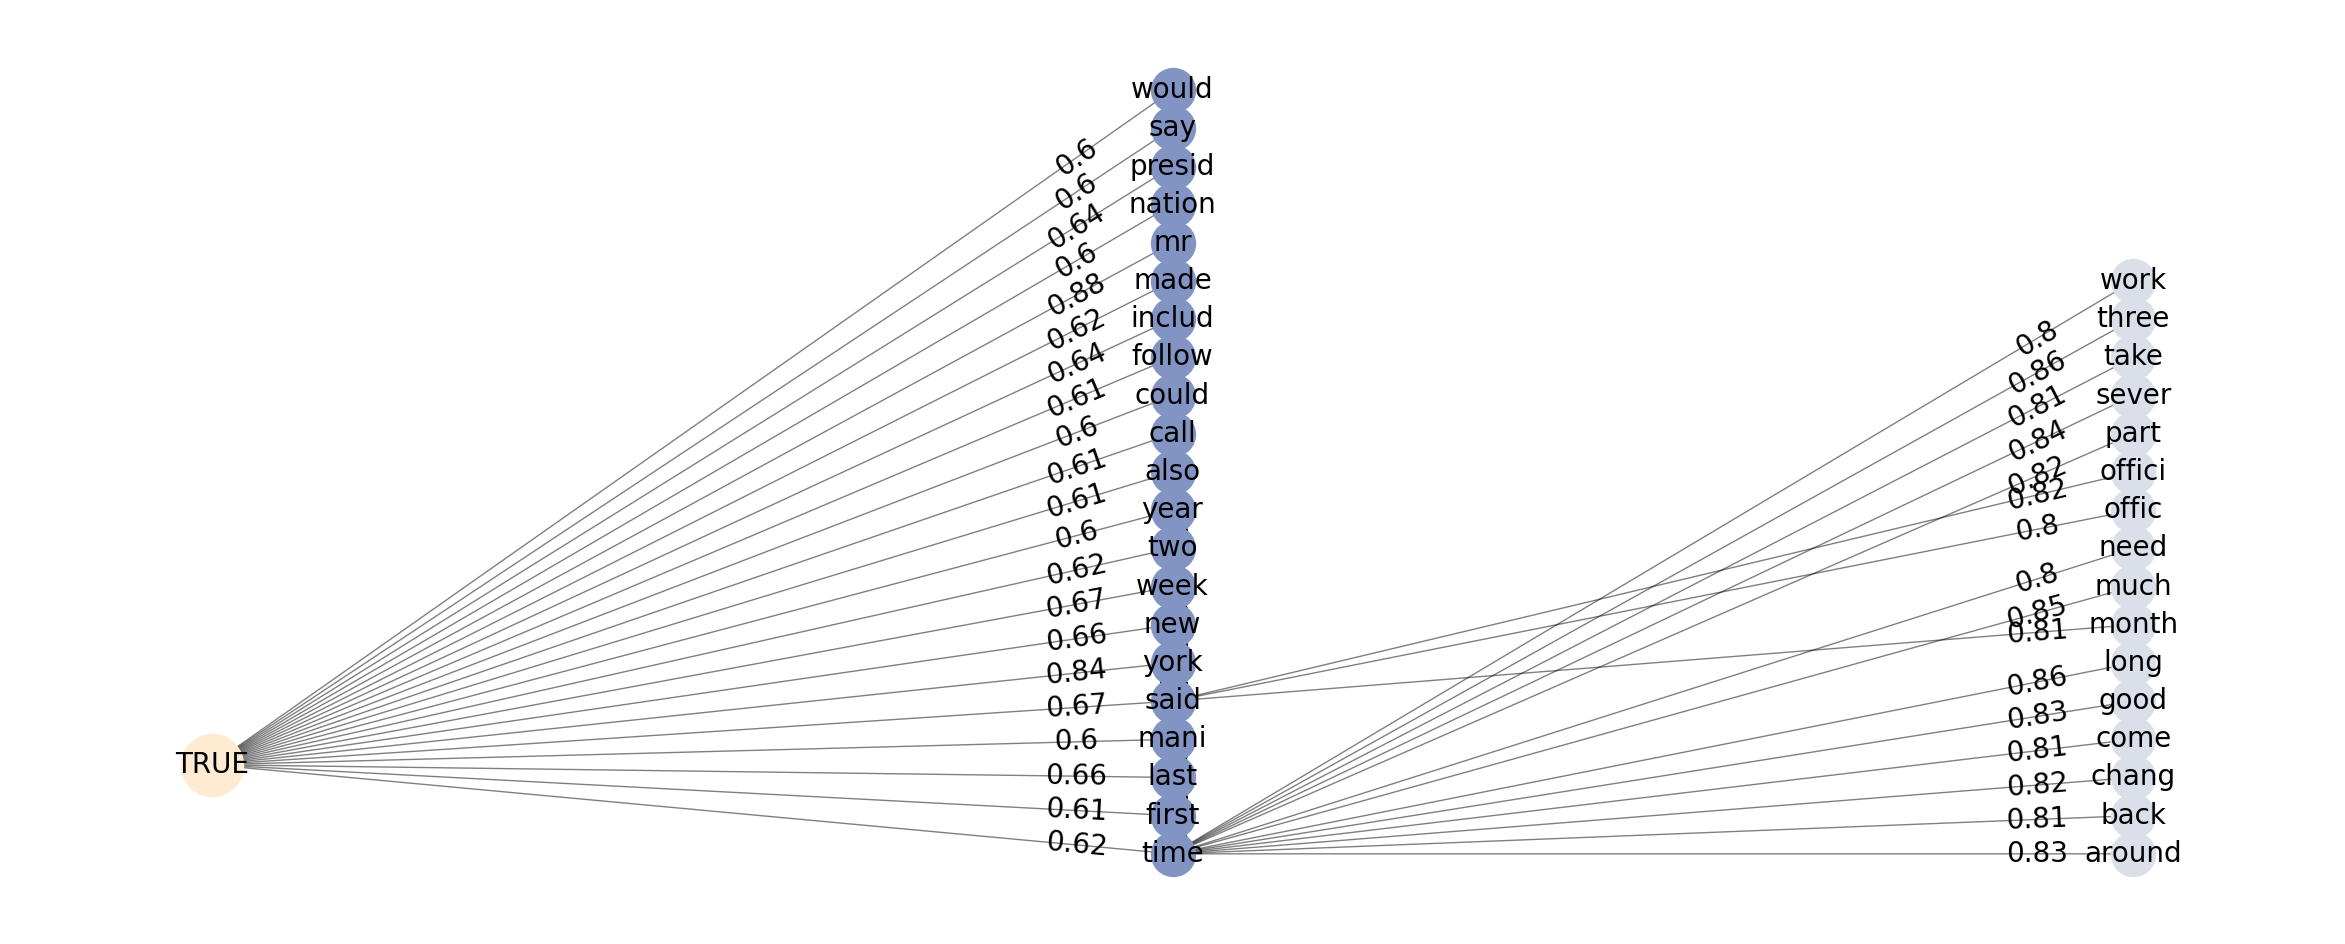

In [66]:
decimales = 2

# Seleccionamos las reglas que tienen una confianza grande
reglas_VoF_grafo = reglas_VoF[reglas_VoF['confidence'] >= 0.6]
reglas_conectadas_grafo = reglas_conectadas[reglas_conectadas['confidence'] >= 0.8]

# Creamos un grafo de las reglas, donde los nodos son los elementos y las aristas son las reglas, y el valor de la arista es la confianza
G = nx.DiGraph()

# Añadimos los nodos
for i in range(len(reglas_conectadas_grafo)):
    G.add_node(next(iter(reglas_conectadas_grafo['antecedents'].iloc[i])))
    G.add_node(next(iter(reglas_conectadas_grafo['consequents'].iloc[i])))

for i in range(len(reglas_VoF_grafo)):
    G.add_node(next(iter(reglas_VoF_grafo['antecedents'].iloc[i])))
    G.add_node(next(iter(reglas_VoF_grafo['consequents'].iloc[i])))

# Añadimos las aristas con la confianza como peso
for i in range(len(reglas_conectadas_grafo)):
    G.add_edge(next(iter(reglas_conectadas_grafo['antecedents'].iloc[i])),
               next(iter(reglas_conectadas_grafo['consequents'].iloc[i])),
               weight=math.floor(reglas_conectadas_grafo['confidence'].iloc[i] * 10 ** decimales) / 10 ** decimales)

for i in range(len(reglas_VoF_grafo)):
    G.add_edge(next(iter(reglas_VoF_grafo['antecedents'].iloc[i])),
               next(iter(reglas_VoF_grafo['consequents'].iloc[i])),
               weight=math.floor(reglas_VoF_grafo['confidence'].iloc[i] * 10 ** decimales) / 10 ** decimales)

# Calcular la distancia en aristas de cada nodo al nodo "TRUE"
distancias = nx.shortest_path_length(G, target='TRUE')

# Dibujamos el grafo
plt.figure(figsize=(30, 12))

# Borramos los nodos que no están conectados con TRUE
lista_borrar = []
for node in G.nodes:
    if distancias.get(node) == None and node != 'TRUE':
        lista_borrar.append(node)
        
for node in lista_borrar:
    G.remove_node(node)
            
# Quitamos de distancias los nodos que no están conectados con TRUE
for node in list(distancias.keys()):
    if node not in G.nodes:
        del distancias[node]
print(G.nodes)

# Ordenar los nodos por distancia al nodo "TRUE"
sorted_nodes = sorted(G.nodes, key=lambda x: distancias[x])

# Asignar posiciones a los nodos según las distancias
pos_final = {}
x_spacing = 1.5  # Espaciado horizontal entre los nodos
y_spacing = 1.0  # Espaciado vertical entre los niveles
y_offset = 0.0

primera_distancia_1 = True
primera_distancia_2 = True
for nodo in sorted_nodes:
    if distancias.get(node) != None:
        distancia = distancias[nodo]
        x_offset = x_spacing * distancia
        if distancia == 0:
            y_offset = 10
        elif distancia == 1 and primera_distancia_1:
            primera_distancia_1 = False
            y_offset = 3
        elif distancia == 1 and not primera_distancia_1:
            y_offset += 3
        elif distancia == 2 and primera_distancia_2:
            primera_distancia_2 = False
            y_offset = 3
        elif distancia == 2 and not primera_distancia_2:
            y_offset += 3
        pos_final[nodo] = (x_offset, y_offset)

# Dibujamos los nodos en diferentes colores según su nivel
for node in G.nodes:
    if distancias.get(node) != None:
        if distancias[node] == 0:
            nx.draw_networkx_nodes(G, pos_final, nodelist=[node], node_size=2000, node_color='#ffead2')
        elif distancias[node] == 1:
            nx.draw_networkx_nodes(G, pos_final, nodelist=[node], node_size=1000, node_color='#8294c4')
        elif distancias[node] == 2:
            nx.draw_networkx_nodes(G, pos_final, nodelist=[node], node_size=1000, node_color='#dbdfea')

# Dibujamos las aristas curvadas entre nodos del mismo nivel
same_level_edges = [(u, v, d) for u, v, d in G.edges(data=True) if distancias[u] == distancias[v]]
different_level_edges = [(u, v, d) for u, v, d in G.edges(data=True) if distancias[u] != distancias[v]]

nx.draw_networkx_edges(G, pos_final, edgelist=same_level_edges, connectionstyle="arc3,rad=0", alpha=0.5, edge_color='black')
nx.draw_networkx_edges(G, pos_final, edgelist=different_level_edges, alpha=0.5, edge_color='black')

nx.draw_networkx_labels(G, pos_final, font_size=20, font_color='black')

edge_labels = nx.get_edge_attributes(G, 'weight')
    
# Ajustamos la posición de las etiquetas a lo largo de las aristas curvadas
curved_edge_labels = {}
for edge, weight in edge_labels.items():
    if edge in same_level_edges:
        u, v = edge[:2]
        x1, y1 = pos_final[u]
        x2, y2 = pos_final[v]
        label_pos = (x1 + x2) / 2, (y1 + y2) / 2
        curved_edge_labels[edge] = {'weight': weight, 'label_pos': label_pos}
    else:
        curved_edge_labels[edge] = weight

# No ponemos borde a la figura
plt.box(False)

nx.draw_networkx_edge_labels(G, pos_final, edge_labels=curved_edge_labels, label_pos=0.9, font_size=20, bbox=dict(facecolor='none', edgecolor='none'))
#plt.savefig('../images/reglas_maximales3.png')
plt.show()

In [ ]:
decimales = 2

# Seleccionamos las reglas que tienen una confianza grande
reglas_VoF_grafo = reglas_VoF
reglas_conectadas_grafo = reglas_conectadas

# Creamos un grafo de las reglas, donde los nodos son los elementos y las aristas son las reglas, y el valor de la arista es la confianza
G = nx.DiGraph()

# Añadimos los nodos
for i in range(len(reglas_conectadas_grafo)):
    G.add_node(next(iter(reglas_conectadas_grafo['antecedents'].iloc[i])))
    G.add_node(next(iter(reglas_conectadas_grafo['consequents'].iloc[i])))

for i in range(len(reglas_VoF_grafo)):
    G.add_node(next(iter(reglas_VoF_grafo['antecedents'].iloc[i])))
    G.add_node(next(iter(reglas_VoF_grafo['consequents'].iloc[i])))

# Añadimos las aristas con la confianza como peso
for i in range(len(reglas_conectadas_grafo)):
    G.add_edge(next(iter(reglas_conectadas_grafo['antecedents'].iloc[i])),
               next(iter(reglas_conectadas_grafo['consequents'].iloc[i])),
               weight=math.floor(reglas_conectadas_grafo['confidence'].iloc[i] * 10 ** decimales) / 10 ** decimales)

for i in range(len(reglas_VoF_grafo)):
    G.add_edge(next(iter(reglas_VoF_grafo['antecedents'].iloc[i])),
               next(iter(reglas_VoF_grafo['consequents'].iloc[i])),
               weight=math.floor(reglas_VoF_grafo['confidence'].iloc[i] * 10 ** decimales) / 10 ** decimales)

# Asignamos colores a los nodos según su nivel
colores = []
for node in G.nodes:
    if distancias[node] == 0:
        colores.append('#ffead2')
    elif distancias[node] == 1:
        colores.append('#8294c4')
    elif distancias[node] == 2:
        colores.append('#dbdfea')

# Dibujamos el grafo
plt.figure(figsize=(20, 14))
pos = nx.spring_layout(G, k=1, weight='weight')  # Ajusta el valor de k según tus necesidades
nx.draw(G, pos, with_labels=True, font_size=20, node_size=2000, node_color='lightblue', edge_color='black', width=1)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=20)
 # Dibujamos el grafo añadiendo los colores
nx.draw(G, pos, with_labels=True, font_size=20, node_size=2000, node_color=colores, edge_color='black', width=1)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=20,bbox=dict(facecolor='none', edgecolor='none'))

plt.savefig('../images/reglas_maximales4.png')
plt.show()

### Obtención reglas FALSE

In [67]:
# Escogemos las palabras conectadas con solo False
palabras_conectadas = set()
nuevas = set([list(x)[0] for x in reglas_F['antecedents']])
while len(nuevas) > 0:
    palabras_conectadas.update(nuevas)
    palabras_conectadas_aux = nuevas.copy()
    nuevas = set()
    for ant in palabras_conectadas_aux:
        nuevas.update(set(reglas_intermedias[reglas_intermedias.apply(lambda x: list(x['consequents'])[0] == ant, axis=1)]['antecedents'].apply(lambda x: list(x)[0]).tolist()))
    nuevas.difference_update(palabras_conectadas)

In [ ]:
len(palabras_conectadas)

In [68]:
# Nos quedamos con las reglas donde tanto el antecedente como el consecuente son palabras conectadas
reglas_conectadas = reglas_intermedias[reglas_intermedias.apply(lambda x: list(x['antecedents'])[0] in palabras_conectadas and list(x['consequents'])[0] in palabras_conectadas, axis=1)]

In [ ]:
len(reglas_conectadas)

In [ ]:
max(reglas_conectadas['confidence'])

In [ ]:
max(reglas_conectadas['lift'])

In [ ]:
# Vemos la interseccion entre palabras_conectadas y los antecedentes de reglas_F
len(set(reglas_F['antecedents'].apply(lambda x: list(x)[0]).tolist()).intersection(palabras_conectadas))

### Grafo de Asociación para FALSE

In [ ]:
decimales = 2

# Seleccionamos las reglas
reglas_VoF_grafo = reglas_F
reglas_conectadas_grafo = reglas_conectadas[reglas_conectadas['confidence'] >= 0.9]


# Creamos un grafo de las reglas, donde los nodos son los elementos y las aristas son las reglas, y el valor de la arista es la confianza
G = nx.DiGraph()


# Añadimos los nodos
for i in range(len(reglas_conectadas_grafo)):
    G.add_node(next(iter(reglas_conectadas_grafo['antecedents'].iloc[i])))
    G.add_node(next(iter(reglas_conectadas_grafo['consequents'].iloc[i])))

for i in range(len(reglas_VoF_grafo)):
    G.add_node(next(iter(reglas_VoF_grafo['antecedents'].iloc[i])))
    G.add_node(next(iter(reglas_VoF_grafo['consequents'].iloc[i])))
    

# Añadimos las aristas con la confianza como peso
for i in range(len(reglas_conectadas_grafo)):
    G.add_edge(next(iter(reglas_conectadas_grafo['antecedents'].iloc[i])),
               next(iter(reglas_conectadas_grafo['consequents'].iloc[i])),
               weight=math.floor(reglas_conectadas_grafo['confidence'].iloc[i] * 10 ** decimales) / 10 ** decimales)

for i in range(len(reglas_VoF_grafo)):
    G.add_edge(next(iter(reglas_VoF_grafo['antecedents'].iloc[i])),
               next(iter(reglas_VoF_grafo['consequents'].iloc[i])),
               weight=math.floor(reglas_VoF_grafo['confidence'].iloc[i] * 10 ** decimales) / 10 ** decimales)

# Calcular la distancia en aristas de cada nodo al nodo "FALSE"
distancias = nx.shortest_path_length(G, target='FALSE')
eliminar = []

# Vemos los nodos que no están en distancias, y los borramos
for node in G.nodes:
    if node not in distancias.keys():
        eliminar.append(node)        
G.remove_nodes_from(eliminar)

# Asignamos colores a los nodos según su nivel
colores = []
for node in G.nodes:
    # Comprobamos si existe la distancia en el diccionario de distancias, ya que puede que no exista
    if distancias.get(node) != None:
        if distancias[node] == 0:
            colores.append('#ffead2')
        elif distancias[node] == 1:
            colores.append('#8294c4')
        elif distancias[node] == 2:
            colores.append('#dbdfea')

# Dibujamos el grafo
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=1, weight='weight')  # Ajusta el valor de k según tus necesidades
nx.draw(G, pos, with_labels=True, font_size=20, node_size=2000, node_color='lightblue', edge_color='black', width=1)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=20, bbox=dict(facecolor='none', edgecolor='none'))
 # Dibujamos el grafo añadiendo los colores
nx.draw(G, pos, with_labels=True, font_size=20, node_size=2000, node_color=colores, edge_color='black', width=1)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=20,bbox=dict(facecolor='none', edgecolor='none'))

plt.savefig('../images/reglas_maximales_false.png')
plt.show()

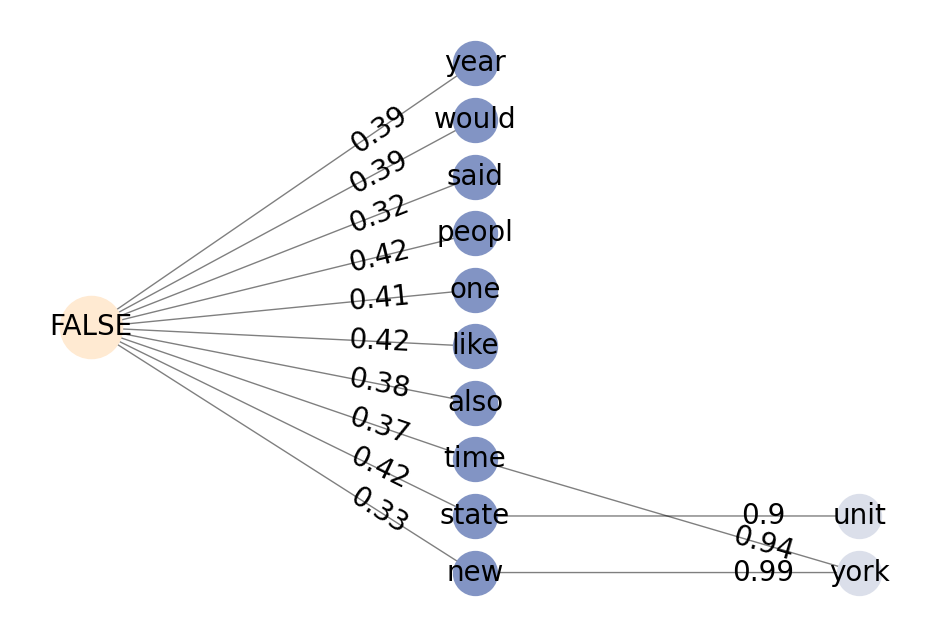

In [71]:
decimales = 2

# Seleccionamos las reglas
reglas_VoF_grafo = reglas_F
reglas_conectadas_grafo = reglas_conectadas[reglas_conectadas['confidence'] >= 0.9]


# Creamos un grafo de las reglas, donde los nodos son los elementos y las aristas son las reglas, y el valor de la arista es la confianza
G = nx.DiGraph()

# Añadimos los nodos
for i in range(len(reglas_conectadas_grafo)):
    G.add_node(next(iter(reglas_conectadas_grafo['antecedents'].iloc[i])))
    G.add_node(next(iter(reglas_conectadas_grafo['consequents'].iloc[i])))

for i in range(len(reglas_VoF_grafo)):
    G.add_node(next(iter(reglas_VoF_grafo['antecedents'].iloc[i])))
    G.add_node(next(iter(reglas_VoF_grafo['consequents'].iloc[i])))

# Añadimos las aristas con la confianza como peso
for i in range(len(reglas_conectadas_grafo)):
    G.add_edge(next(iter(reglas_conectadas_grafo['antecedents'].iloc[i])),
               next(iter(reglas_conectadas_grafo['consequents'].iloc[i])),
               weight=math.floor(reglas_conectadas_grafo['confidence'].iloc[i] * 10 ** decimales) / 10 ** decimales)

for i in range(len(reglas_VoF_grafo)):
    G.add_edge(next(iter(reglas_VoF_grafo['antecedents'].iloc[i])),
               next(iter(reglas_VoF_grafo['consequents'].iloc[i])),
               weight=math.floor(reglas_VoF_grafo['confidence'].iloc[i] * 10 ** decimales) / 10 ** decimales)

# Calcular la distancia en aristas de cada nodo al nodo "FALSE"
distancias = nx.shortest_path_length(G, target='FALSE')
eliminar = []

# Vemos los nodos que no están en distancias, y los borramos
for node in G.nodes:
    if node not in distancias.keys():
        eliminar.append(node)        
G.remove_nodes_from(eliminar)

# Dibujamos el grafo
plt.figure(figsize=(12, 8))

# Convertimos las posiciones a tuplas
pos = nx.spring_layout(G, k=1.5, weight='weight')
pos = {node: tuple(coord) for node, coord in pos.items()}

# Ordenar los nodos por distancia al nodo "TRUE"
sorted_nodes = sorted(G.nodes, key=lambda x: distancias[x])

# Asignar posiciones a los nodos según las distancias
pos_final = {}
x_spacing = 1.5  # Espaciado horizontal entre los nodos
y_spacing = 1.0  # Espaciado vertical entre los niveles
y_offset = 0.0

primera_distancia_1 = True
primera_distancia_2 = True
for nodo in sorted_nodes:
    distancia = distancias[nodo]
    x_offset = x_spacing * distancia
    if distancia == 0:
        y_offset = 16
    elif distancia == 1 and primera_distancia_1:
        primera_distancia_1 = False
        y_offset = 3
    elif distancia == 1 and not primera_distancia_1:
        y_offset += 3
    elif distancia == 2 and primera_distancia_2:
        primera_distancia_2 = False
        y_offset = 3
    elif distancia == 2 and not primera_distancia_2:
        y_offset += 3
    pos_final[nodo] = (x_offset, y_offset)

# Dibujamos los nodos en diferentes colores según su nivel
for node in G.nodes:
    if distancias[node] == 0:
        nx.draw_networkx_nodes(G, pos_final, nodelist=[node], node_size=2000, node_color='#ffead2')
    elif distancias[node] == 1:
        nx.draw_networkx_nodes(G, pos_final, nodelist=[node], node_size=1000, node_color='#8294c4')
    elif distancias[node] == 2:
        nx.draw_networkx_nodes(G, pos_final, nodelist=[node], node_size=1000, node_color='#dbdfea')

# Dibujamos las aristas curvadas entre nodos del mismo nivel
same_level_edges = [(u, v, d) for u, v, d in G.edges(data=True) if distancias[u] == distancias[v]]
different_level_edges = [(u, v, d) for u, v, d in G.edges(data=True) if distancias[u] != distancias[v]]

nx.draw_networkx_edges(G, pos_final, edgelist=same_level_edges, connectionstyle="arc3,rad=1", alpha=0.5, edge_color='black')
nx.draw_networkx_edges(G, pos_final, edgelist=different_level_edges, alpha=0.5, edge_color='black')

nx.draw_networkx_labels(G, pos_final, font_size=20, font_color='black')

edge_labels = nx.get_edge_attributes(G, 'weight')

# Ajustamos la posición de las etiquetas a lo largo de las aristas curvadas
curved_edge_labels = {}
for edge, weight in edge_labels.items():
    if edge in same_level_edges:
        u, v = edge[:2]
        x1, y1 = pos_final[u]
        x2, y2 = pos_final[v]
        label_pos = (x1 + x2) / 2, (y1 + y2) / 2
        curved_edge_labels[edge] = {'weight': weight, 'label_pos': label_pos}
    else:
        curved_edge_labels[edge] = weight
# No ponemos borde a la figura
plt.box(False)
nx.draw_networkx_edge_labels(G, pos_final, edge_labels=curved_edge_labels, label_pos=0.75, font_size=20, bbox=dict(facecolor='none', edgecolor='none'))
#plt.savefig('../images/reglas_maximales_false2.png')
plt.show()

In [ ]:
# Comprobamos si el grafo tiene ciclos
nx.is_directed_acyclic_graph(G)